In [ ]:
!pip3 install -r requirements.txt

In [2]:
import matplotlib
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import sys
from tqdm.notebook import tqdm, trange
from time import sleep

from zoo import models
from common.data_loader import DataLoader
from util import visualize_model

## Device configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Configuration

In [13]:
num_epochs = 90
num_classes = 10
batch_size = 512
learning_rate = 0.001
momentum = 0.9


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Pad(3),
    transforms.RandomCrop(32),
    transforms.RandomAffine(degrees=2),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

## Load data

In [5]:
data_loader = DataLoader()
data_loader.set_transform(transform)
train_data = data_loader.get_train_data(batch_size)
test_data = data_loader.get_test_data(batch_size)

Files already downloaded and verified


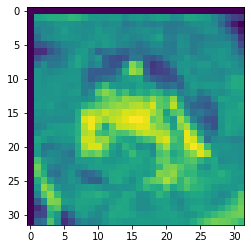

In [6]:
import matplotlib.pyplot as plt
plt.ion()
plt.imshow(train_data.dataset[0][0][0, :, ::])

In [7]:
print(train_data.__dict__)

{'dataset': Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Pad(padding=3, fill=0, padding_mode=constant)
               RandomCrop(size=(32, 32), padding=None)
               RandomAffine(degrees=[-2.0, 2.0])
               ToTensor()
           ), 'num_workers': 0, 'prefetch_factor': 2, 'pin_memory': False, 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 512, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7f346467cd90>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7f33b7f1dd60>, 'generator': None, 'collate_fn': <function default_collate at 0x7f33b9e1eaf0>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


In [8]:
import inspect

models_ = []
for name, obj in inspect.getmembers(models):
    if inspect.isclass(obj) and inspect.getmodule(obj).__name__.split(".")[-1] == "models":
        models_.append(obj())
        print (obj().__class__.__name__)


baselineModel
leakyModel
resnet18Model


## Train model

In [ ]:
print(models_)

In [17]:
def train_model(model):
    losses = []
    epochs = []
    metrics = []
    total_step = len(train_data)
    with tqdm(total=num_epochs, file=sys.stdout) as pbar:
      for epoch in range(num_epochs):
        model.train()
        glloss = 0
        for i, (images, labels) in enumerate(train_data):
            # Place training batch onto the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            outputs = model(images)

            # Compute loss.
            loss = loss_function(outputs, labels)

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers(i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

            glloss = loss.item()

        # Save the model checkpoint
        metric = eval_model(model)
        metrics.append(metric)
        epochs.append(epoch + 1)
        # print(f"Current epoch is {epoch + 1},  current loss is {glloss}, val accuracy is {metric}")
        pbar.update(1)
        losses.append(glloss)
        torch.save(model.state_dict(), f'model_{model.__class__.__name__}.ckpt')

    return losses, epochs, metrics

## Evaluate model

In [18]:
def eval_model(model):
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance; dropout disabled)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_data:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        # print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_data), accuracy))
        return accuracy

## Base Pipeline


Current model is baselineModel


  0%|          | 0/90 [00:00<?, ?it/s]

baselineModel best accuracy is 86.69


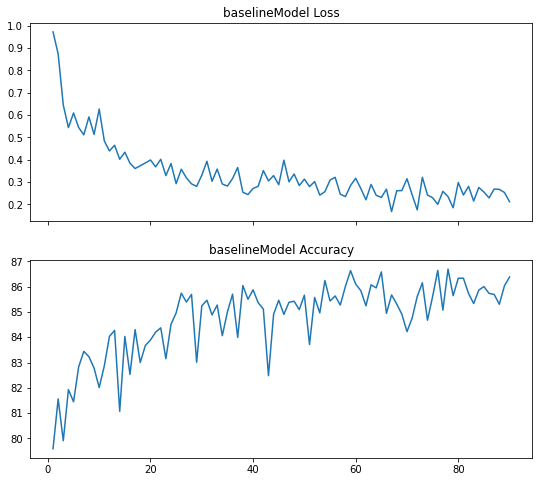


Current model is leakyModel


  0%|          | 0/90 [00:00<?, ?it/s]

leakyModel best accuracy is 86.95


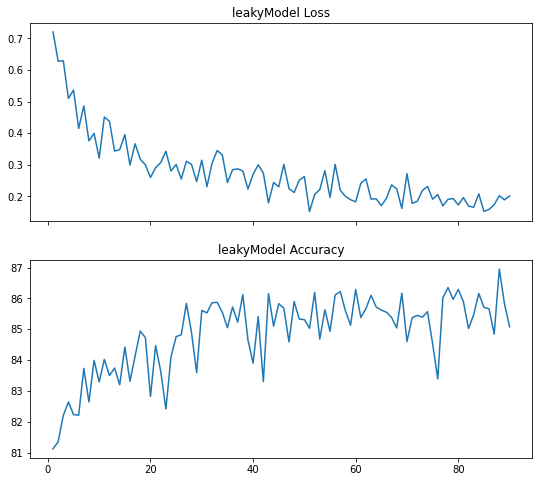


Current model is resnet18Model


  0%|          | 0/90 [00:00<?, ?it/s]

resnet18Model best accuracy is 80.4


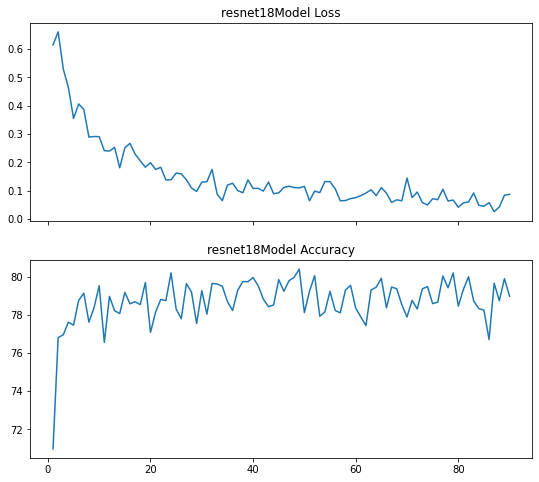

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for model in models_:
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 8))
    print(f"\nCurrent model is {model.__class__.__name__}")
    model.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
                                 
    losses, epochs, metrics = train_model(model)

    ax1.plot(epochs, losses)
    ax1.set_title(f"{model.__class__.__name__} Loss")
    ax2.plot(epochs, metrics)
    ax2.set_title(f"{model.__class__.__name__} Accuracy")

    print(f"{model.__class__.__name__} best accuracy is {np.max(metrics)}")
    plt.show()

78.66% - baseline

84.85% - top

86.09% - 70 iter

86.42% - 90 iter